# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [2]:
# can comment out after executing
!unzip processed_celeba_small.zip

Archive:  processed_celeba_small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.CenterCrop(image_size),
                                    transforms.ToTensor()])
    celeb_data = datasets.ImageFolder(data_dir, transform=transform)
    celeb_dataLoader = torch.utils.data.DataLoader(celeb_data, batch_size = batch_size, shuffle = True)
    
    return celeb_dataLoader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

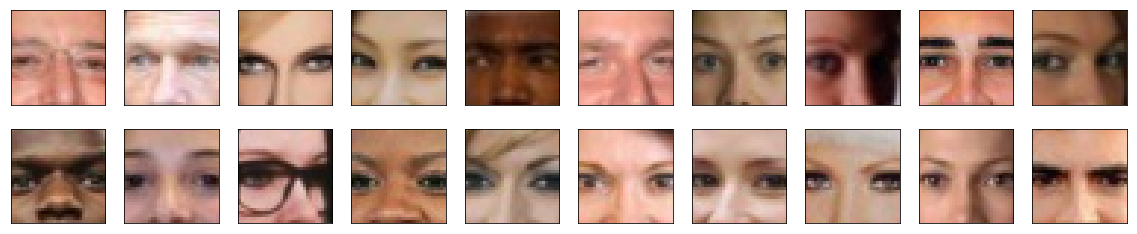

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    mini, maxi = feature_range
    x = x * (maxi - mini) + mini
    
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8118)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def conv(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, batch_norm = True):
    
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, kernel_size = 4, stride = 2, padding = 1, batch_norm = False)
        self.conv2 = conv(conv_dim , conv_dim * 2, kernel_size = 4, stride = 2, padding = 1, batch_norm = True)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, kernel_size = 4, stride = 2, padding =1 , batch_norm = True)
        
        self.fc = nn.Linear(conv_dim * 4 * 4 *4 , 1)
        # complete init function
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        x = x.view(-1, self.conv_dim * 4 * 4 * 4)
        
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
def deconv(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, batch_norm = True):
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, bias = False)
    layers.append(deconv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.fc = nn.Linear(z_size, conv_dim * 4 * 4 * 4)
        
        self.conv_dim = conv_dim
        self.deconv1 = deconv(conv_dim * 4, conv_dim * 2, kernel_size = 4, stride = 2, padding = 1, batch_norm = True)
        self.deconv2 = deconv(conv_dim * 2, conv_dim, kernel_size = 4, stride = 2, padding = 1, batch_norm = True)
        self.deconv3 = deconv(conv_dim, 3, kernel_size = 4, stride = 2, padding = 1, batch_norm = False)
        # complete init function
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim * 4, 4, 4)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.tanh(self.deconv3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [13]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data,0, 0.02)
        
#     elif classname.find('BatchNorm2d') != -1:
#         init.normal_(m.weight.data, 1.0, 0.02)
#         init.constant_(m.bias.data, 0.0)
    
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [39]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [75]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
#     print("D_out size is {}".format(D_out.shape))
    labels = torch.ones(batch_size)
#     print("labels size is {}".format(labels.shape))
    criterion = nn.BCEWithLogitsLoss()
    if train_on_gpu:
        labels = labels.cuda()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
#     print("D_out size is {}".format(D_out.shape))
    labels = torch.zeros(batch_size)
#     print("labels size is {}".format(labels.shape))
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [76]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(),0.0002, [0.5, 0.999])
g_optimizer = optim.Adam(G.parameters(),0.0002, [0.5, 0.999])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [81]:
import numpy as np
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
                real_images = real_images.cuda()
            d_optimizer.zero_grad()
            out = D(real_images)
            r_loss = real_loss(out)
            out_g = G(z)
            fake_disc_out = D(out_g)
            f_loss = fake_loss(fake_disc_out)
            
            d_loss = r_loss + f_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            out_g = G(z)
            fake_disc_out = D(out_g)
            
            g_loss = real_loss(fake_disc_out)
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [82]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 0.4868 | g_loss: 1.8742
Epoch [    1/  100] | d_loss: 0.1541 | g_loss: 3.2642
Epoch [    1/  100] | d_loss: 0.1053 | g_loss: 5.1146
Epoch [    1/  100] | d_loss: 0.6796 | g_loss: 1.1016
Epoch [    1/  100] | d_loss: 0.4119 | g_loss: 3.6454
Epoch [    1/  100] | d_loss: 0.1100 | g_loss: 3.7066
Epoch [    1/  100] | d_loss: 0.2734 | g_loss: 2.2730
Epoch [    1/  100] | d_loss: 0.3704 | g_loss: 1.9189
Epoch [    1/  100] | d_loss: 0.3962 | g_loss: 3.7561
Epoch [    1/  100] | d_loss: 0.4925 | g_loss: 2.7449
Epoch [    1/  100] | d_loss: 0.4362 | g_loss: 2.0995
Epoch [    1/  100] | d_loss: 0.2508 | g_loss: 3.5775
Epoch [    1/  100] | d_loss: 0.6509 | g_loss: 2.0549
Epoch [    1/  100] | d_loss: 0.7511 | g_loss: 1.7404
Epoch [    1/  100] | d_loss: 1.1985 | g_loss: 1.1072
Epoch [    1/  100] | d_loss: 0.6196 | g_loss: 2.7121
Epoch [    1/  100] | d_loss: 0.6142 | g_loss: 1.7215
Epoch [    1/  100] | d_loss: 0.8777 | g_loss: 2.1809
Epoch [    1/  100] | d_loss

Epoch [    6/  100] | d_loss: 0.4362 | g_loss: 1.7039
Epoch [    6/  100] | d_loss: 0.5109 | g_loss: 2.3304
Epoch [    6/  100] | d_loss: 0.3500 | g_loss: 2.8439
Epoch [    6/  100] | d_loss: 0.4353 | g_loss: 2.3472
Epoch [    6/  100] | d_loss: 0.5716 | g_loss: 1.6076
Epoch [    6/  100] | d_loss: 0.3590 | g_loss: 2.3517
Epoch [    6/  100] | d_loss: 1.2022 | g_loss: 5.0180
Epoch [    6/  100] | d_loss: 0.4263 | g_loss: 2.0751
Epoch [    6/  100] | d_loss: 0.6273 | g_loss: 2.6887
Epoch [    6/  100] | d_loss: 0.4936 | g_loss: 1.9405
Epoch [    6/  100] | d_loss: 0.3857 | g_loss: 1.6570
Epoch [    6/  100] | d_loss: 0.4154 | g_loss: 2.1427
Epoch [    6/  100] | d_loss: 0.5206 | g_loss: 2.2835
Epoch [    6/  100] | d_loss: 0.5290 | g_loss: 2.3444
Epoch [    6/  100] | d_loss: 0.6128 | g_loss: 1.4246
Epoch [    6/  100] | d_loss: 0.4638 | g_loss: 1.3979
Epoch [    6/  100] | d_loss: 0.5125 | g_loss: 1.4796
Epoch [    6/  100] | d_loss: 0.3769 | g_loss: 1.8327
Epoch [    6/  100] | d_loss

Epoch [   11/  100] | d_loss: 0.1810 | g_loss: 3.1108
Epoch [   11/  100] | d_loss: 0.1892 | g_loss: 2.6089
Epoch [   11/  100] | d_loss: 0.3424 | g_loss: 2.1469
Epoch [   11/  100] | d_loss: 0.2571 | g_loss: 2.7815
Epoch [   11/  100] | d_loss: 0.4392 | g_loss: 2.6910
Epoch [   11/  100] | d_loss: 1.4536 | g_loss: 1.6687
Epoch [   11/  100] | d_loss: 0.2785 | g_loss: 2.4100
Epoch [   11/  100] | d_loss: 0.2418 | g_loss: 1.5088
Epoch [   11/  100] | d_loss: 0.1748 | g_loss: 3.0804
Epoch [   11/  100] | d_loss: 0.3091 | g_loss: 2.2633
Epoch [   11/  100] | d_loss: 0.4527 | g_loss: 1.2275
Epoch [   11/  100] | d_loss: 0.4966 | g_loss: 3.0482
Epoch [   11/  100] | d_loss: 0.2902 | g_loss: 3.2663
Epoch [   11/  100] | d_loss: 0.4025 | g_loss: 2.8425
Epoch [   11/  100] | d_loss: 0.2229 | g_loss: 3.1194
Epoch [   12/  100] | d_loss: 0.3564 | g_loss: 3.8229
Epoch [   12/  100] | d_loss: 0.2555 | g_loss: 3.2349
Epoch [   12/  100] | d_loss: 1.1764 | g_loss: 5.7902
Epoch [   12/  100] | d_loss

Epoch [   16/  100] | d_loss: 0.1892 | g_loss: 3.6864
Epoch [   16/  100] | d_loss: 0.1834 | g_loss: 3.0369
Epoch [   16/  100] | d_loss: 0.0975 | g_loss: 3.2237
Epoch [   16/  100] | d_loss: 0.2366 | g_loss: 2.4431
Epoch [   16/  100] | d_loss: 0.6632 | g_loss: 2.5797
Epoch [   16/  100] | d_loss: 0.2127 | g_loss: 4.0413
Epoch [   16/  100] | d_loss: 0.1880 | g_loss: 3.2378
Epoch [   16/  100] | d_loss: 0.0971 | g_loss: 4.0174
Epoch [   17/  100] | d_loss: 0.5786 | g_loss: 0.7440
Epoch [   17/  100] | d_loss: 0.3926 | g_loss: 3.6915
Epoch [   17/  100] | d_loss: 0.1956 | g_loss: 3.4452
Epoch [   17/  100] | d_loss: 1.9506 | g_loss: 2.5812
Epoch [   17/  100] | d_loss: 0.2600 | g_loss: 3.5662
Epoch [   17/  100] | d_loss: 0.0864 | g_loss: 2.7173
Epoch [   17/  100] | d_loss: 0.2944 | g_loss: 3.4299
Epoch [   17/  100] | d_loss: 0.1795 | g_loss: 3.7524
Epoch [   17/  100] | d_loss: 0.5162 | g_loss: 2.3380
Epoch [   17/  100] | d_loss: 0.3925 | g_loss: 2.3557
Epoch [   17/  100] | d_loss

Epoch [   21/  100] | d_loss: 0.1124 | g_loss: 3.2494
Epoch [   22/  100] | d_loss: 0.0914 | g_loss: 3.1869
Epoch [   22/  100] | d_loss: 0.0998 | g_loss: 3.4949
Epoch [   22/  100] | d_loss: 0.1645 | g_loss: 2.0579
Epoch [   22/  100] | d_loss: 0.1899 | g_loss: 4.4928
Epoch [   22/  100] | d_loss: 0.1115 | g_loss: 3.0088
Epoch [   22/  100] | d_loss: 0.6607 | g_loss: 2.3283
Epoch [   22/  100] | d_loss: 0.9428 | g_loss: 1.5070
Epoch [   22/  100] | d_loss: 0.2502 | g_loss: 2.3052
Epoch [   22/  100] | d_loss: 0.1403 | g_loss: 4.3759
Epoch [   22/  100] | d_loss: 0.1193 | g_loss: 3.7045
Epoch [   22/  100] | d_loss: 0.1469 | g_loss: 2.3257
Epoch [   22/  100] | d_loss: 0.9409 | g_loss: 1.2986
Epoch [   22/  100] | d_loss: 0.1482 | g_loss: 2.4631
Epoch [   22/  100] | d_loss: 0.1516 | g_loss: 4.6170
Epoch [   22/  100] | d_loss: 2.5225 | g_loss: 0.4127
Epoch [   22/  100] | d_loss: 0.4883 | g_loss: 2.4008
Epoch [   22/  100] | d_loss: 0.2831 | g_loss: 2.8305
Epoch [   22/  100] | d_loss

Epoch [   27/  100] | d_loss: 0.1700 | g_loss: 3.3423
Epoch [   27/  100] | d_loss: 0.2108 | g_loss: 3.0999
Epoch [   27/  100] | d_loss: 0.1246 | g_loss: 3.7937
Epoch [   27/  100] | d_loss: 0.0892 | g_loss: 2.7091
Epoch [   27/  100] | d_loss: 0.0701 | g_loss: 2.5653
Epoch [   27/  100] | d_loss: 0.0662 | g_loss: 4.1668
Epoch [   27/  100] | d_loss: 0.0776 | g_loss: 4.0782
Epoch [   27/  100] | d_loss: 0.1152 | g_loss: 4.4456
Epoch [   27/  100] | d_loss: 0.0728 | g_loss: 4.0612
Epoch [   27/  100] | d_loss: 0.0364 | g_loss: 5.8300
Epoch [   27/  100] | d_loss: 0.3826 | g_loss: 3.1918
Epoch [   27/  100] | d_loss: 1.1213 | g_loss: 0.3779
Epoch [   27/  100] | d_loss: 0.1390 | g_loss: 3.7169
Epoch [   27/  100] | d_loss: 0.1977 | g_loss: 2.8406
Epoch [   27/  100] | d_loss: 0.0992 | g_loss: 3.7075
Epoch [   27/  100] | d_loss: 0.0716 | g_loss: 4.7612
Epoch [   27/  100] | d_loss: 0.0797 | g_loss: 3.3789
Epoch [   27/  100] | d_loss: 0.7022 | g_loss: 1.7692
Epoch [   27/  100] | d_loss

Epoch [   32/  100] | d_loss: 0.1514 | g_loss: 4.8424
Epoch [   32/  100] | d_loss: 0.0816 | g_loss: 3.7177
Epoch [   32/  100] | d_loss: 0.1009 | g_loss: 4.4504
Epoch [   32/  100] | d_loss: 0.0868 | g_loss: 4.1280
Epoch [   32/  100] | d_loss: 0.2100 | g_loss: 3.3261
Epoch [   32/  100] | d_loss: 1.2057 | g_loss: 2.0064
Epoch [   32/  100] | d_loss: 0.4881 | g_loss: 3.8772
Epoch [   32/  100] | d_loss: 0.2326 | g_loss: 4.0110
Epoch [   32/  100] | d_loss: 0.1158 | g_loss: 5.1837
Epoch [   32/  100] | d_loss: 0.2167 | g_loss: 2.1518
Epoch [   32/  100] | d_loss: 0.2056 | g_loss: 4.0763
Epoch [   32/  100] | d_loss: 0.0858 | g_loss: 4.2030
Epoch [   32/  100] | d_loss: 0.0948 | g_loss: 3.6325
Epoch [   32/  100] | d_loss: 0.0439 | g_loss: 4.4089
Epoch [   32/  100] | d_loss: 0.5995 | g_loss: 1.5533
Epoch [   32/  100] | d_loss: 0.2072 | g_loss: 3.5291
Epoch [   33/  100] | d_loss: 0.9246 | g_loss: 6.3310
Epoch [   33/  100] | d_loss: 0.1300 | g_loss: 4.1420
Epoch [   33/  100] | d_loss

Epoch [   37/  100] | d_loss: 1.1273 | g_loss: 7.5638
Epoch [   37/  100] | d_loss: 0.5584 | g_loss: 1.9294
Epoch [   37/  100] | d_loss: 0.1259 | g_loss: 3.3638
Epoch [   37/  100] | d_loss: 0.0739 | g_loss: 2.7174
Epoch [   37/  100] | d_loss: 0.8287 | g_loss: 2.6406
Epoch [   37/  100] | d_loss: 0.2109 | g_loss: 4.6024
Epoch [   37/  100] | d_loss: 0.0278 | g_loss: 4.4124
Epoch [   37/  100] | d_loss: 0.0794 | g_loss: 3.6599
Epoch [   37/  100] | d_loss: 0.1451 | g_loss: 3.2138
Epoch [   38/  100] | d_loss: 0.0312 | g_loss: 3.3760
Epoch [   38/  100] | d_loss: 0.1380 | g_loss: 5.1113
Epoch [   38/  100] | d_loss: 0.5846 | g_loss: 1.4878
Epoch [   38/  100] | d_loss: 0.1303 | g_loss: 4.6257
Epoch [   38/  100] | d_loss: 0.0289 | g_loss: 5.0587
Epoch [   38/  100] | d_loss: 0.1617 | g_loss: 4.3658
Epoch [   38/  100] | d_loss: 0.0406 | g_loss: 4.2306
Epoch [   38/  100] | d_loss: 0.1334 | g_loss: 3.6739
Epoch [   38/  100] | d_loss: 0.0448 | g_loss: 4.7477
Epoch [   38/  100] | d_loss

Epoch [   42/  100] | d_loss: 0.1729 | g_loss: 2.7937
Epoch [   42/  100] | d_loss: 0.1606 | g_loss: 4.9944
Epoch [   43/  100] | d_loss: 0.0864 | g_loss: 3.8002
Epoch [   43/  100] | d_loss: 0.1086 | g_loss: 3.5053
Epoch [   43/  100] | d_loss: 0.0599 | g_loss: 4.2155
Epoch [   43/  100] | d_loss: 0.2989 | g_loss: 5.5804
Epoch [   43/  100] | d_loss: 0.0631 | g_loss: 4.4174
Epoch [   43/  100] | d_loss: 0.2129 | g_loss: 5.0003
Epoch [   43/  100] | d_loss: 0.0180 | g_loss: 3.1621
Epoch [   43/  100] | d_loss: 0.1091 | g_loss: 4.6844
Epoch [   43/  100] | d_loss: 0.0356 | g_loss: 4.6936
Epoch [   43/  100] | d_loss: 0.0731 | g_loss: 5.1928
Epoch [   43/  100] | d_loss: 0.0308 | g_loss: 3.8652
Epoch [   43/  100] | d_loss: 0.5905 | g_loss: 1.3541
Epoch [   43/  100] | d_loss: 1.2290 | g_loss: 0.5814
Epoch [   43/  100] | d_loss: 0.0766 | g_loss: 3.6324
Epoch [   43/  100] | d_loss: 0.0897 | g_loss: 4.6727
Epoch [   43/  100] | d_loss: 0.4992 | g_loss: 2.4891
Epoch [   43/  100] | d_loss

Epoch [   48/  100] | d_loss: 0.0666 | g_loss: 3.0720
Epoch [   48/  100] | d_loss: 0.0511 | g_loss: 4.9858
Epoch [   48/  100] | d_loss: 0.0746 | g_loss: 4.7407
Epoch [   48/  100] | d_loss: 0.0484 | g_loss: 5.0043
Epoch [   48/  100] | d_loss: 0.0267 | g_loss: 5.2982
Epoch [   48/  100] | d_loss: 0.0409 | g_loss: 5.0349
Epoch [   48/  100] | d_loss: 0.0362 | g_loss: 4.0356
Epoch [   48/  100] | d_loss: 1.5701 | g_loss: 2.4836
Epoch [   48/  100] | d_loss: 0.0744 | g_loss: 5.3790
Epoch [   48/  100] | d_loss: 0.1053 | g_loss: 3.5871
Epoch [   48/  100] | d_loss: 0.0134 | g_loss: 6.7841
Epoch [   48/  100] | d_loss: 0.0697 | g_loss: 4.7621
Epoch [   48/  100] | d_loss: 0.6661 | g_loss: 2.2070
Epoch [   48/  100] | d_loss: 0.0634 | g_loss: 3.5386
Epoch [   48/  100] | d_loss: 0.0166 | g_loss: 4.8351
Epoch [   48/  100] | d_loss: 0.2857 | g_loss: 3.1366
Epoch [   48/  100] | d_loss: 0.5706 | g_loss: 1.8071
Epoch [   48/  100] | d_loss: 0.0948 | g_loss: 5.8288
Epoch [   48/  100] | d_loss

Epoch [   53/  100] | d_loss: 0.0510 | g_loss: 5.2175
Epoch [   53/  100] | d_loss: 0.1071 | g_loss: 4.3229
Epoch [   53/  100] | d_loss: 0.0177 | g_loss: 4.1357
Epoch [   53/  100] | d_loss: 0.0291 | g_loss: 5.1758
Epoch [   53/  100] | d_loss: 0.0292 | g_loss: 6.7039
Epoch [   53/  100] | d_loss: 0.0681 | g_loss: 4.7458
Epoch [   53/  100] | d_loss: 0.0238 | g_loss: 6.2963
Epoch [   53/  100] | d_loss: 0.0196 | g_loss: 5.0949
Epoch [   53/  100] | d_loss: 0.0322 | g_loss: 4.2383
Epoch [   53/  100] | d_loss: 0.0400 | g_loss: 6.1381
Epoch [   53/  100] | d_loss: 0.8609 | g_loss: 0.6674
Epoch [   53/  100] | d_loss: 0.1067 | g_loss: 3.9498
Epoch [   53/  100] | d_loss: 0.0813 | g_loss: 4.5447
Epoch [   53/  100] | d_loss: 0.3762 | g_loss: 4.4066
Epoch [   53/  100] | d_loss: 0.0907 | g_loss: 4.7106
Epoch [   53/  100] | d_loss: 0.1370 | g_loss: 4.3076
Epoch [   53/  100] | d_loss: 0.0810 | g_loss: 4.8778
Epoch [   54/  100] | d_loss: 0.0198 | g_loss: 6.5156
Epoch [   54/  100] | d_loss

Epoch [   58/  100] | d_loss: 0.1089 | g_loss: 5.2959
Epoch [   58/  100] | d_loss: 0.0564 | g_loss: 5.0003
Epoch [   58/  100] | d_loss: 0.0711 | g_loss: 5.3965
Epoch [   58/  100] | d_loss: 0.2555 | g_loss: 2.4488
Epoch [   58/  100] | d_loss: 0.0575 | g_loss: 5.8481
Epoch [   58/  100] | d_loss: 0.0858 | g_loss: 4.9723
Epoch [   58/  100] | d_loss: 0.0306 | g_loss: 5.3963
Epoch [   58/  100] | d_loss: 0.0508 | g_loss: 5.6292
Epoch [   58/  100] | d_loss: 0.0289 | g_loss: 5.2140
Epoch [   58/  100] | d_loss: 0.0113 | g_loss: 4.1031
Epoch [   59/  100] | d_loss: 0.0384 | g_loss: 5.5070
Epoch [   59/  100] | d_loss: 0.0569 | g_loss: 6.1279
Epoch [   59/  100] | d_loss: 0.2519 | g_loss: 3.3839
Epoch [   59/  100] | d_loss: 0.0997 | g_loss: 3.6054
Epoch [   59/  100] | d_loss: 0.0389 | g_loss: 4.6050
Epoch [   59/  100] | d_loss: 0.0315 | g_loss: 4.8839
Epoch [   59/  100] | d_loss: 0.0522 | g_loss: 4.4640
Epoch [   59/  100] | d_loss: 0.0064 | g_loss: 5.1682
Epoch [   59/  100] | d_loss

Epoch [   63/  100] | d_loss: 0.0277 | g_loss: 5.4022
Epoch [   63/  100] | d_loss: 0.0200 | g_loss: 4.5425
Epoch [   63/  100] | d_loss: 0.0175 | g_loss: 4.6141
Epoch [   64/  100] | d_loss: 0.0413 | g_loss: 3.9778
Epoch [   64/  100] | d_loss: 0.0463 | g_loss: 5.5269
Epoch [   64/  100] | d_loss: 0.1633 | g_loss: 3.5176
Epoch [   64/  100] | d_loss: 0.0353 | g_loss: 4.6732
Epoch [   64/  100] | d_loss: 0.0627 | g_loss: 5.1907
Epoch [   64/  100] | d_loss: 0.0197 | g_loss: 5.5030
Epoch [   64/  100] | d_loss: 0.0399 | g_loss: 4.1259
Epoch [   64/  100] | d_loss: 0.0638 | g_loss: 4.6867
Epoch [   64/  100] | d_loss: 0.1069 | g_loss: 4.9787
Epoch [   64/  100] | d_loss: 0.1716 | g_loss: 2.6006
Epoch [   64/  100] | d_loss: 0.1421 | g_loss: 2.5565
Epoch [   64/  100] | d_loss: 0.0899 | g_loss: 5.4364
Epoch [   64/  100] | d_loss: 0.0500 | g_loss: 3.7365
Epoch [   64/  100] | d_loss: 0.0434 | g_loss: 4.6377
Epoch [   64/  100] | d_loss: 0.0242 | g_loss: 4.4817
Epoch [   64/  100] | d_loss

Epoch [   69/  100] | d_loss: 0.0463 | g_loss: 5.1107
Epoch [   69/  100] | d_loss: 0.0288 | g_loss: 4.6030
Epoch [   69/  100] | d_loss: 0.0885 | g_loss: 6.1634
Epoch [   69/  100] | d_loss: 0.0158 | g_loss: 5.5960
Epoch [   69/  100] | d_loss: 0.0222 | g_loss: 5.1912
Epoch [   69/  100] | d_loss: 0.4123 | g_loss: 2.5869
Epoch [   69/  100] | d_loss: 0.3213 | g_loss: 3.4743
Epoch [   69/  100] | d_loss: 0.1904 | g_loss: 3.6754
Epoch [   69/  100] | d_loss: 0.1006 | g_loss: 4.6525
Epoch [   69/  100] | d_loss: 0.0920 | g_loss: 4.5926
Epoch [   69/  100] | d_loss: 0.0417 | g_loss: 4.7724
Epoch [   69/  100] | d_loss: 0.0483 | g_loss: 5.8065
Epoch [   69/  100] | d_loss: 0.0126 | g_loss: 5.3567
Epoch [   69/  100] | d_loss: 0.0322 | g_loss: 4.0347
Epoch [   69/  100] | d_loss: 0.0564 | g_loss: 6.7505
Epoch [   69/  100] | d_loss: 0.0351 | g_loss: 4.7732
Epoch [   69/  100] | d_loss: 0.0844 | g_loss: 5.8415
Epoch [   69/  100] | d_loss: 0.1333 | g_loss: 4.2627
Epoch [   69/  100] | d_loss

Epoch [   74/  100] | d_loss: 0.0222 | g_loss: 6.0284
Epoch [   74/  100] | d_loss: 0.1118 | g_loss: 5.0926
Epoch [   74/  100] | d_loss: 0.1031 | g_loss: 5.0268
Epoch [   74/  100] | d_loss: 0.0733 | g_loss: 3.5701
Epoch [   74/  100] | d_loss: 0.0282 | g_loss: 5.6224
Epoch [   74/  100] | d_loss: 0.0324 | g_loss: 6.8953
Epoch [   74/  100] | d_loss: 0.0100 | g_loss: 6.9472
Epoch [   74/  100] | d_loss: 0.0191 | g_loss: 5.9427
Epoch [   74/  100] | d_loss: 1.1842 | g_loss: 1.2957
Epoch [   74/  100] | d_loss: 0.3531 | g_loss: 4.2325
Epoch [   74/  100] | d_loss: 0.2570 | g_loss: 1.9745
Epoch [   74/  100] | d_loss: 0.0393 | g_loss: 5.9985
Epoch [   74/  100] | d_loss: 0.0258 | g_loss: 4.5050
Epoch [   74/  100] | d_loss: 0.0962 | g_loss: 3.6649
Epoch [   74/  100] | d_loss: 0.0111 | g_loss: 5.0147
Epoch [   74/  100] | d_loss: 0.0684 | g_loss: 4.9669
Epoch [   74/  100] | d_loss: 0.0246 | g_loss: 6.2631
Epoch [   74/  100] | d_loss: 0.0272 | g_loss: 5.7182
Epoch [   75/  100] | d_loss

Epoch [   79/  100] | d_loss: 0.0387 | g_loss: 6.1530
Epoch [   79/  100] | d_loss: 0.0349 | g_loss: 5.0658
Epoch [   79/  100] | d_loss: 0.0093 | g_loss: 5.4437
Epoch [   79/  100] | d_loss: 0.0131 | g_loss: 4.8368
Epoch [   79/  100] | d_loss: 0.0178 | g_loss: 6.9287
Epoch [   79/  100] | d_loss: 0.0970 | g_loss: 5.1773
Epoch [   79/  100] | d_loss: 0.1079 | g_loss: 3.5433
Epoch [   79/  100] | d_loss: 0.0415 | g_loss: 4.9070
Epoch [   79/  100] | d_loss: 0.0785 | g_loss: 5.4866
Epoch [   79/  100] | d_loss: 0.0321 | g_loss: 4.2287
Epoch [   79/  100] | d_loss: 0.0566 | g_loss: 4.2212
Epoch [   80/  100] | d_loss: 0.0230 | g_loss: 5.1511
Epoch [   80/  100] | d_loss: 0.0221 | g_loss: 6.1669
Epoch [   80/  100] | d_loss: 0.0096 | g_loss: 4.9699
Epoch [   80/  100] | d_loss: 0.0725 | g_loss: 4.3925
Epoch [   80/  100] | d_loss: 0.0287 | g_loss: 7.3710
Epoch [   80/  100] | d_loss: 0.0284 | g_loss: 7.2624
Epoch [   80/  100] | d_loss: 0.0671 | g_loss: 5.2100
Epoch [   80/  100] | d_loss

Epoch [   84/  100] | d_loss: 0.0413 | g_loss: 4.5561
Epoch [   84/  100] | d_loss: 0.0345 | g_loss: 4.5324
Epoch [   84/  100] | d_loss: 0.1139 | g_loss: 4.5358
Epoch [   84/  100] | d_loss: 0.0329 | g_loss: 5.7247
Epoch [   85/  100] | d_loss: 3.1054 | g_loss: 10.2657
Epoch [   85/  100] | d_loss: 0.7957 | g_loss: 2.5148
Epoch [   85/  100] | d_loss: 0.8528 | g_loss: 5.1936
Epoch [   85/  100] | d_loss: 0.0341 | g_loss: 5.0457
Epoch [   85/  100] | d_loss: 0.0516 | g_loss: 4.4853
Epoch [   85/  100] | d_loss: 0.0100 | g_loss: 4.0903
Epoch [   85/  100] | d_loss: 0.0955 | g_loss: 5.0361
Epoch [   85/  100] | d_loss: 0.0878 | g_loss: 7.4311
Epoch [   85/  100] | d_loss: 0.0569 | g_loss: 6.4201
Epoch [   85/  100] | d_loss: 0.0409 | g_loss: 4.7885
Epoch [   85/  100] | d_loss: 0.0125 | g_loss: 5.7344
Epoch [   85/  100] | d_loss: 0.0160 | g_loss: 7.3020
Epoch [   85/  100] | d_loss: 0.0131 | g_loss: 5.0506
Epoch [   85/  100] | d_loss: 0.0219 | g_loss: 5.3572
Epoch [   85/  100] | d_los

Epoch [   90/  100] | d_loss: 0.0751 | g_loss: 4.5435
Epoch [   90/  100] | d_loss: 0.0563 | g_loss: 4.0020
Epoch [   90/  100] | d_loss: 0.0639 | g_loss: 5.1310
Epoch [   90/  100] | d_loss: 0.0238 | g_loss: 5.5401
Epoch [   90/  100] | d_loss: 0.0397 | g_loss: 5.2285
Epoch [   90/  100] | d_loss: 0.0771 | g_loss: 5.0416
Epoch [   90/  100] | d_loss: 0.0235 | g_loss: 6.8566
Epoch [   90/  100] | d_loss: 0.0209 | g_loss: 6.3841
Epoch [   90/  100] | d_loss: 0.0158 | g_loss: 6.8495
Epoch [   90/  100] | d_loss: 0.0271 | g_loss: 5.5327
Epoch [   90/  100] | d_loss: 0.0218 | g_loss: 5.6647
Epoch [   90/  100] | d_loss: 0.0255 | g_loss: 6.6771
Epoch [   90/  100] | d_loss: 0.0353 | g_loss: 6.2546
Epoch [   90/  100] | d_loss: 0.0122 | g_loss: 4.4604
Epoch [   90/  100] | d_loss: 0.0257 | g_loss: 5.9314
Epoch [   90/  100] | d_loss: 0.0419 | g_loss: 7.5541
Epoch [   90/  100] | d_loss: 0.0302 | g_loss: 5.3836
Epoch [   90/  100] | d_loss: 0.0391 | g_loss: 3.9096
Epoch [   90/  100] | d_loss

Epoch [   95/  100] | d_loss: 0.0402 | g_loss: 4.4361
Epoch [   95/  100] | d_loss: 0.0138 | g_loss: 5.3249
Epoch [   95/  100] | d_loss: 0.0167 | g_loss: 6.3684
Epoch [   95/  100] | d_loss: 0.0171 | g_loss: 4.9730
Epoch [   95/  100] | d_loss: 0.0070 | g_loss: 5.9405
Epoch [   95/  100] | d_loss: 0.0613 | g_loss: 4.8365
Epoch [   95/  100] | d_loss: 0.0087 | g_loss: 4.8771
Epoch [   95/  100] | d_loss: 1.2587 | g_loss: 3.2987
Epoch [   95/  100] | d_loss: 0.0953 | g_loss: 4.4545
Epoch [   95/  100] | d_loss: 0.0854 | g_loss: 6.1546
Epoch [   95/  100] | d_loss: 0.0584 | g_loss: 4.7043
Epoch [   95/  100] | d_loss: 0.0420 | g_loss: 4.0355
Epoch [   95/  100] | d_loss: 0.0352 | g_loss: 4.8597
Epoch [   95/  100] | d_loss: 0.0341 | g_loss: 5.4230
Epoch [   95/  100] | d_loss: 0.2430 | g_loss: 5.7835
Epoch [   95/  100] | d_loss: 0.0554 | g_loss: 4.9438
Epoch [   95/  100] | d_loss: 0.0403 | g_loss: 6.4179
Epoch [   95/  100] | d_loss: 0.0250 | g_loss: 6.8335
Epoch [   95/  100] | d_loss

Epoch [  100/  100] | d_loss: 0.0090 | g_loss: 4.8226
Epoch [  100/  100] | d_loss: 0.0231 | g_loss: 6.1911
Epoch [  100/  100] | d_loss: 0.0272 | g_loss: 6.6601
Epoch [  100/  100] | d_loss: 0.0455 | g_loss: 5.4925
Epoch [  100/  100] | d_loss: 0.0055 | g_loss: 7.0981
Epoch [  100/  100] | d_loss: 0.0433 | g_loss: 4.8016
Epoch [  100/  100] | d_loss: 0.0214 | g_loss: 6.4190
Epoch [  100/  100] | d_loss: 0.0256 | g_loss: 5.7669
Epoch [  100/  100] | d_loss: 0.0077 | g_loss: 6.8180
Epoch [  100/  100] | d_loss: 0.4600 | g_loss: 2.5416
Epoch [  100/  100] | d_loss: 0.1487 | g_loss: 5.5079
Epoch [  100/  100] | d_loss: 0.9071 | g_loss: 0.9399


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

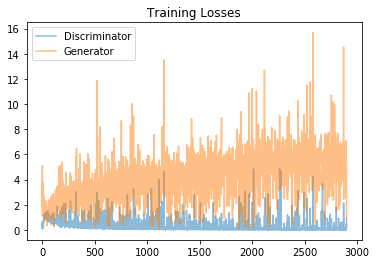

In [83]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [84]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [85]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

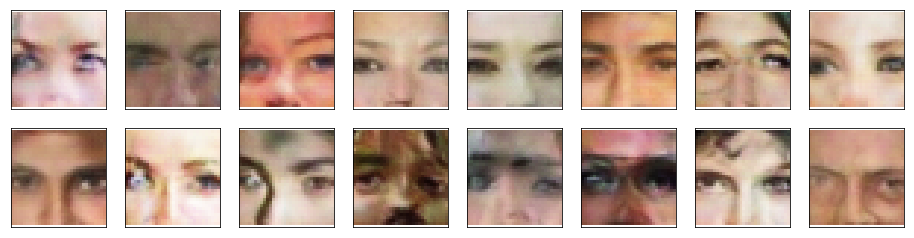

In [86]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)<br>
I think the model has done a good job in generating the images close to human faces !! (still looks generated though)<br>
I think the model will improve if we have a wide range of faces and were able to apply this process for a bigger image which have all the features <br>
It would also improve the model if we would have trained the GAN for some more epochs

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.